# Visualize phylogenetic trees

Import Python packages:

In [17]:
import collections
import itertools
import math
import os

import Bio.SeqIO

import pandas as pd

import ete3

Get variables from `snakemake`:

In [18]:

######## snakemake preamble start (automatically inserted, do not edit) ########
import sys; sys.path.extend(['/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2_PRJNA612766/lib/python3.8/site-packages', '/home/jbloom/SARS-CoV-2_PRJNA612766/notebooks']); import pickle; snakemake = pickle.loads(b"\x80\x04\x95\xbd*\x00\x00\x00\x00\x00\x00\x8c\x10snakemake.script\x94\x8c\tSnakemake\x94\x93\x94)\x81\x94}\x94(\x8c\x05input\x94\x8c\x0csnakemake.io\x94\x8c\nInputFiles\x94\x93\x94)\x81\x94(\x8c7results/phylogenetics/all_hCoV-19%USA%WA1%2020.treefile\x94\x8cDresults/phylogenetics/all_hCoV-19%Guangdong%HKU-SZ-002%2020.treefile\x94\x8c@results/phylogenetics/all_hCoV-19%Shandong%LY005-2%2020.treefile\x94\x8c4results/phylogenetics/all_hCoV-19%USA%WA1%2020.state\x94\x8cAresults/phylogenetics/all_hCoV-19%Guangdong%HKU-SZ-002%2020.state\x94\x8c=results/phylogenetics/all_hCoV-19%Shandong%LY005-2%2020.state\x94\x8c&results/phylogenetics/all_alignment.fa\x94\x8c'results/phylogenetics/all_alignment.csv\x94\x8c*results/phylogenetics/region_alignment.csv\x94\x8c2results/genome_to_comparator/site_identity_map.csv\x94e}\x94(\x8c\x06_names\x94}\x94(\x8c\x05trees\x94K\x00K\x03\x86\x94\x8c\x06states\x94K\x03K\x06\x86\x94\x8c\talignment\x94K\x06N\x86\x94\x8c\x07all_csv\x94K\x07N\x86\x94\x8c\nregion_csv\x94K\x08N\x86\x94\x8c\x0ecomparator_map\x94K\tN\x86\x94u\x8c\x12_allowed_overrides\x94]\x94(\x8c\x05index\x94\x8c\x04sort\x94eh%\x8c\tfunctools\x94\x8c\x07partial\x94\x93\x94h\x06\x8c\x19Namedlist._used_attribute\x94\x93\x94\x85\x94R\x94(h+)}\x94\x8c\x05_name\x94h%sNt\x94bh&h)h+\x85\x94R\x94(h+)}\x94h/h&sNt\x94bh\x17h\x06\x8c\tNamedlist\x94\x93\x94)\x81\x94(h\nh\x0bh\x0ce}\x94(h\x15}\x94h#]\x94(h%h&eh%h)h+\x85\x94R\x94(h+)}\x94h/h%sNt\x94bh&h)h+\x85\x94R\x94(h+)}\x94h/h&sNt\x94bubh\x19h6)\x81\x94(h\rh\x0eh\x0fe}\x94(h\x15}\x94h#]\x94(h%h&eh%h)h+\x85\x94R\x94(h+)}\x94h/h%sNt\x94bh&h)h+\x85\x94R\x94(h+)}\x94h/h&sNt\x94bubh\x1bh\x10h\x1dh\x11h\x1fh\x12h!h\x13ub\x8c\x06output\x94h\x06\x8c\x0bOutputFiles\x94\x93\x94)\x81\x94\x8c\x0btree_images\x94a}\x94(h\x15}\x94h#]\x94(h%h&eh%h)h+\x85\x94R\x94(h+)}\x94h/h%sNt\x94bh&h)h+\x85\x94R\x94(h+)}\x94h/h&sNt\x94bub\x8c\x06params\x94h\x06\x8c\x06Params\x94\x93\x94)\x81\x94(M\t\x01]\x94(\x8c\x14hCoV-19/USA/WA1/2020\x94\x8c!hCoV-19/Guangdong/HKU-SZ-002/2020\x94\x8c\x1dhCoV-19/Shandong/LY005-2/2020\x94ee}\x94(h\x15}\x94(\x8c\x0bsite_offset\x94K\x00N\x86\x94\x8c\x0bprogenitors\x94K\x01N\x86\x94uh#]\x94(h%h&eh%h)h+\x85\x94R\x94(h+)}\x94h/h%sNt\x94bh&h)h+\x85\x94R\x94(h+)}\x94h/h&sNt\x94bhiM\t\x01hkhcub\x8c\twildcards\x94h\x06\x8c\tWildcards\x94\x93\x94)\x81\x94}\x94(h\x15}\x94h#]\x94(h%h&eh%h)h+\x85\x94R\x94(h+)}\x94h/h%sNt\x94bh&h)h+\x85\x94R\x94(h+)}\x94h/h&sNt\x94bub\x8c\x07threads\x94K\x01\x8c\tresources\x94h\x06\x8c\tResources\x94\x93\x94)\x81\x94(K\x01K\x01e}\x94(h\x15}\x94(\x8c\x06_cores\x94K\x00N\x86\x94\x8c\x06_nodes\x94K\x01N\x86\x94uh#]\x94(h%h&eh%h)h+\x85\x94R\x94(h+)}\x94h/h%sNt\x94bh&h)h+\x85\x94R\x94(h+)}\x94h/h&sNt\x94bh\x8cK\x01h\x8eK\x01ub\x8c\x03log\x94h\x06\x8c\x03Log\x94\x93\x94)\x81\x94\x8c,results/logs/notebooks/visualize_trees.ipynb\x94a}\x94(h\x15}\x94\x8c\x08notebook\x94K\x00N\x86\x94sh#]\x94(h%h&eh%h)h+\x85\x94R\x94(h+)}\x94h/h%sNt\x94bh&h)h+\x85\x94R\x94(h+)}\x94h/h&sNt\x94bh\xa0h\x9dub\x8c\x06config\x94}\x94(\x8c\x08max_cpus\x94K\x04\x8c\x0bscratch_dir\x94\x8c\x11results/_scratch/\x94\x8c\nref_genome\x94}\x94(\x8c\x05fasta\x94\x8c}ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/009/858/895/GCF_009858895.2_ASM985889v3/GCF_009858895.2_ASM985889v3_genomic.fna.gz\x94\x8c\x03gff\x94\x8c}ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/009/858/895/GCF_009858895.2_ASM985889v3/GCF_009858895.2_ASM985889v3_genomic.gff.gz\x94\x8c\x04name\x94\x8c\x07proCoV2\x94\x8c\radd_mutations\x94]\x94(\x8c\x06C8782T\x94\x8c\x07C18060T\x94\x8c\x07T28144C\x94eu\x8c\x12comparator_genomes\x94}\x94(\x8c\x06RaTG13\x94}\x94\x8c\x06gisaid\x94\x8c\x0eEPI_ISL_402131\x94s\x8c\x06RpYN06\x94}\x94\x8c\x06gisaid\x94\x8c\x0fEPI_ISL_1699446\x94s\x8c\x06RmYN02\x94}\x94\x8c\x06gisaid\x94\x8c\x0eEPI_ISL_412977\x94su\x8c\x16gisaid_comparator_dirs\x94]\x94\x8c\x1edata/comparator_genomes_gisaid\x94a\x8c\nearly_seqs\x94}\x94\x8c\x06gisaid\x94}\x94\x8c\x16gisaid_through_Feb2020\x94\x8c&data/gisaid_sequences_through_Feb2020/\x94ss\x8c\x16early_seq_header_props\x94]\x94(\x8c\x06strain\x94\x8c\x0egisaid_epi_isl\x94\x8c\x04date\x94\x8c\x11genbank_accession\x94\x8c\x07country\x94\x8c\x08location\x94\x8c\x03age\x94\x8c\x03sex\x94e\x8c\x08aligners\x94]\x94\x8c\x08minimap2\x94a\x8c\x04minq\x94K\x14\x8c\x0fmin_read_length\x94K\x14\x8c\x16consensus_min_coverage\x94K\x03\x8c\x12consensus_min_frac\x94G?\xe9\x99\x99\x99\x99\x99\x9a\x8c\x12region_of_interest\x94}\x94(\x8c\x05start\x94MBT\x8c\x03end\x94Mnsu\x8c\x16who_china_report_cases\x94\x8c(data/WHO_China_Report_Dec2019_cases.yaml\x94\x8c\x1awho_china_report_last_date\x94\x8c\x08datetime\x94\x8c\x04date\x94\x93\x94C\x04\x07\xe4\x01\x02\x94\x85\x94R\x94\x8c\x15early_seqs_to_exclude\x94\x8c\x19data/seqs_to_exclude.yaml\x94\x8c\x1dearly_seqs_ignore_muts_before\x94M\n\x01\x8c\x1cearly_seqs_ignore_muts_after\x94M\xeas\x8c\x16early_seqs_filter_runs\x94}\x94(\x8c\x06n_muts\x94K\x04\x8c\x04span\x94K\nu\x8c\x17early_seqs_min_coverage\x94G?\xec\xcc\xcc\xcc\xcc\xcc\xcd\x8c\x13early_seqs_max_subs\x94K\x0f\x8c\x18early_seqs_max_ambiguous\x94M\x88\x13\x8c\x13early_seqs_max_date\x94h\xeeC\x04\x07\xe4\x02\x1c\x94\x85\x94R\x94\x8c\x11min_frac_coverage\x94G?\xeeffffff\x8c\x0fphylo_last_date\x94h\xeeC\x04\x07\xe4\x01\x1f\x94\x85\x94R\x94\x8c\x15phylo_min_frac_called\x94G?\xeeffffff\x8c\x14phylo_muts_to_ignore\x94]\x94(\x8c\x06G3564T\x94\x8c\x06G8790T\x94\x8c\x07G24933T\x94\x8c\x06G2198A\x94\x8c\x06G3145T\x94\x8c\x06A3778G\x94\x8c\x06C6255T\x94\x8c\x06A4050C\x94\x8c\x06T8022G\x94\x8c\x07T13402G\x94\x8c\x07A13947T\x94\x8c\x07A24389C\x94\x8c\x07G24390C\x94\x8c\x06G1149T\x94\x8c\x07C22802G\x94\x8c\x05T153G\x94e\x8c\x18phylo_collapse_rare_muts\x94K\x00\x8c\x1aphylo_filter_rare_variants\x94K\x01\x8c\x14samples_fasterq_dump\x94}\x94\x8c\x0csamples_wget\x94}\x94(\x8c\x02A1\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313282\x94\x8c\x0bSRR11313334\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02A2\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313271\x94\x8c\x0bSRR11313461\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02A4\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313417\x94\x8c\x0bSRR11313428\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02A6\x94}\x94(\x8c\naccessions\x94]\x94\x8c\x0bSRR11313479\x94a\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02A9\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313345\x94\x8c\x0bSRR11313356\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03A11\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313455\x94\x8c\x0bSRR11313456\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03A12\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313473\x94\x8c\x0bSRR11313474\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02B1\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313453\x94\x8c\x0bSRR11313454\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02B2\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313451\x94\x8c\x0bSRR11313452\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02B3\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313448\x94\x8c\x0bSRR11313449\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02B4\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313322\x94\x8c\x0bSRR11313333\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02B9\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313445\x94\x8c\x0bSRR11313446\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02C1\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313287\x94\x8c\x0bSRR11313289\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02C2\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313285\x94\x8c\x0bSRR11313286\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02C9\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313441\x94\x8c\x0bSRR11313442\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03C11\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313300\x94\x8c\x0bSRR11313311\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03C12\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313443\x94\x8c\x0bSRR11313444\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02D9\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313436\x94\x8c\x0bSRR11313437\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03D11\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313438\x94\x8c\x0bSRR11313440\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03D12\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313280\x94\x8c\x0bSRR11313281\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02E1\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313276\x94\x8c\x0bSRR11313277\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02E3\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313430\x94\x8c\x0bSRR11313431\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02E5\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313274\x94\x8c\x0bSRR11313275\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02E6\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313427\x94\x8c\x0bSRR11313429\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03E11\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313434\x94\x8c\x0bSRR11313435\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03E12\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313432\x94\x8c\x0bSRR11313433\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02F5\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313270\x94\x8c\x0bSRR11313470\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02F8\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313423\x94\x8c\x0bSRR11313424\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03F11\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313425\x94\x8c\x0bSRR11313426\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02G1\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313468\x94\x8c\x0bSRR11313469\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03G11\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313421\x94\x8c\x0bSRR11313422\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03G12\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313419\x94\x8c\x0bSRR11313420\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02H9\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313464\x94\x8c\x0bSRR11313465\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03H12\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313466\x94\x8c\x0bSRR11313467\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03R01\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313409\x94\x8c\x0bSRR11313410\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R02\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313406\x94\x8c\x0bSRR11313408\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R03\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313269\x94\x8c\x0bSRR11313471\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R04\x94}\x94(\x8c\naccessions\x94]\x94\x8c\x0bSRR11313509\x94a\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R05\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313507\x94\x8c\x0bSRR11313508\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R06\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313505\x94\x8c\x0bSRR11313506\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R07\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313503\x94\x8c\x0bSRR11313504\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R08\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313500\x94\x8c\x0bSRR11313502\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R09\x94}\x94(\x8c\naccessions\x94]\x94\x8c\x0bSRR11313498\x94a\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R10\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313496\x94\x8c\x0bSRR11313497\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R11\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313494\x94\x8c\x0bSRR11313495\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R12\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313492\x94\x8c\x0bSRR11313493\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R13\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313489\x94\x8c\x0bSRR11313491\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R14\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313487\x94\x8c\x0bSRR11313488\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R15\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313485\x94\x8c\x0bSRR11313486\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R16\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313483\x94\x8c\x0bSRR11313484\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94uuu\x8c\x04rule\x94\x8c\x0fvisualize_trees\x94\x8c\x0fbench_iteration\x94N\x8c\tscriptdir\x94\x8c-/home/jbloom/SARS-CoV-2_PRJNA612766/notebooks\x94ub."); from snakemake.logging import logger; logger.printshellcmds = False; import os; os.chdir('/home/jbloom/SARS-CoV-2_PRJNA612766');
######## snakemake preamble end #########


In [19]:
tree_files = snakemake.input.trees
state_files = snakemake.input.states
all_csv = snakemake.input.all_csv
alignment = snakemake.input.alignment
region_csv = snakemake.input.region_csv
comparator_map_csv = snakemake.input.comparator_map
site_offset = snakemake.params.site_offset
progenitors = snakemake.params.progenitors

Read data frames:

In [20]:
all_df = pd.read_csv(all_csv, na_filter=None)

region_df = pd.read_csv(region_csv, na_filter=None)

outgroup_map = pd.read_csv(comparator_map_csv)

Read the reconstructed states and add the tip states, considering only sites where there are multiple identities.
Now we make a matrix of substitutions of each node relative to each other.
Note that in the general case this could get **really slow**, although for the small-ish alignment of similar sequences used here it's fine:

In [21]:
assert len(state_files) == len(tree_files) == len(progenitors)

tip_to_seq = {s.id: list(str(s.seq).upper())
              for s in Bio.SeqIO.parse(alignment, 'fasta')}

tip_states = (
    pd.DataFrame.from_dict(tip_to_seq, orient='index')
    .rename_axis('Node')
    .reset_index()
    .melt(id_vars='Node',
          var_name='Site',
          value_name='State',
          )
    .assign(Site=lambda x: x['Site'] + 1)
    )

subs_matrices = {}

for progenitor, state_file in zip(progenitors, state_files):
    internal_states = (
        pd.read_csv(state_file,
                    sep='\t',
                    comment='#',
                    usecols=['Node', 'Site', 'State'])
        )

    states = (
        internal_states
        .append(tip_states)
        .assign(Site=lambda x: x['Site'] + site_offset,
                n_states_at_site=lambda x: x.groupby('Site')['State'].transform('nunique'),
                )
        .query('n_states_at_site > 1')
        .drop(columns='n_states_at_site')
        )

    states_dict = states.set_index(['Node', 'Site'])['State'].to_dict()

    nodes = states['Node'].unique().tolist()
    sites = sorted(states['Site'].unique())

    subs_matrix = {}  # keyed by (parent, descendant)
    for n1, n2 in itertools.product(nodes, nodes):
        subs = []
        for site in sites:
            nt1 = states_dict[(n1, site)]
            nt2 = states_dict[(n2, site)]
            if nt1 != nt2:
                if nt1 in {'A', 'C', 'G', 'T'} and nt2 in {'A', 'C', 'G', 'T'}:
                    subs.append(f"{nt1}{site}{nt2}")
        subs_matrix[(n1, n2)] = ', '.join(subs)
    subs_matrices[progenitor] = subs_matrix

This next line enables Jupyter notebook rendering of trees in `ete3`:

In [22]:
# to enable jupyter notebook rendering: 
os.environ['QT_QPA_PLATFORM'] = 'offscreen'

List information on the possible progenitors:

In [23]:
pd.set_option('display.max_colwidth', 1000)

display(
    all_df
    .query('representative_strain in @progenitors')
    .assign(all_strains_dates=lambda x: x['all_strains_dates'].str.split(', '))
    [['substitutions', 'representative_strain', 'nstrains', 'all_strains_dates']]
    .set_index(['substitutions', 'representative_strain', 'nstrains'])
    .explode('all_strains_dates')
    )

all_strains_dates
substitutions   representative_strain             nstrains                                                      
                hCoV-19/USA/WA1/2020              6                            hCoV-19/USA/WA1/2020 (2020-01-19)
                                                  6                  hCoV-19/Guangdong/20SF123/2020 (2020-01-20)
                                                  6                           hCoV-19/Fujian/8/2020 (2020-01-21)
                                                  6                  hCoV-19/Guangdong/20SF118/2020 (2020-01-21)
                                                  6                    hCoV-19/Hangzhou/ZJU-08/2020 (2020-01-26)
                                                  6                     hCoV-19/Wuhan/0126-C13/2020 (2020-01-26)
T18060C,C29095T hCoV-19/Guangdong/HKU-SZ-002/2020 9               hCoV-19/Guangdong/HKU-SZ-002/2020 (2020-01-10)
                                                  9                  hCoV-19/Shenzhen/SZTH-002/2020 (2020-01-13)
                                                  9                  hCoV-19/Guangdong/20SF012/2020 (2020-01-14)
                                                  9                  hCoV-19/Guangdong/20SF025/2020 (2020-01-15)
                                                  9                  hCoV-19/Guangdong/20SF013/2020 (2020-01-15)
                                                  9                    hCoV-19/Shanghai/SH0005/2020 (2020-01-28)
                                                  9                   hCoV-19/Vietnam/PIHCM-14/2020 (2020-01-31)
                                                  9                        hCoV-19/Shaoxing/06/2020 (2020-01-31)
                                                  9         hCoV-19/Guangdong/2020XN4276-P0037/2020 (2020-01-31)
T3171C,T18060C  hCoV-19/Shandong/LY005-2/2020     6                   hCoV-19/Shandong/LY005-2/2020 (2020-01-24)
                                                  6              hCoV-19/Shandong/2020C1240402/2020 (2020-01-24)
                                                  6                   hCoV-19/Shandong/LY007-2/2020 (2020-01-25)
                                                  6                   hCoV-19/Shandong/LY006-2/2020 (2020-01-25)
                                                  6                   hCoV-19/Shandong/LY004-2/2020 (2020-01-26)
                                                  6                   hCoV-19/Shandong/LY008-2/2020 (2020-01-30)

Function get and and prettify tree:

hCoV-19/USA/WA1/2020


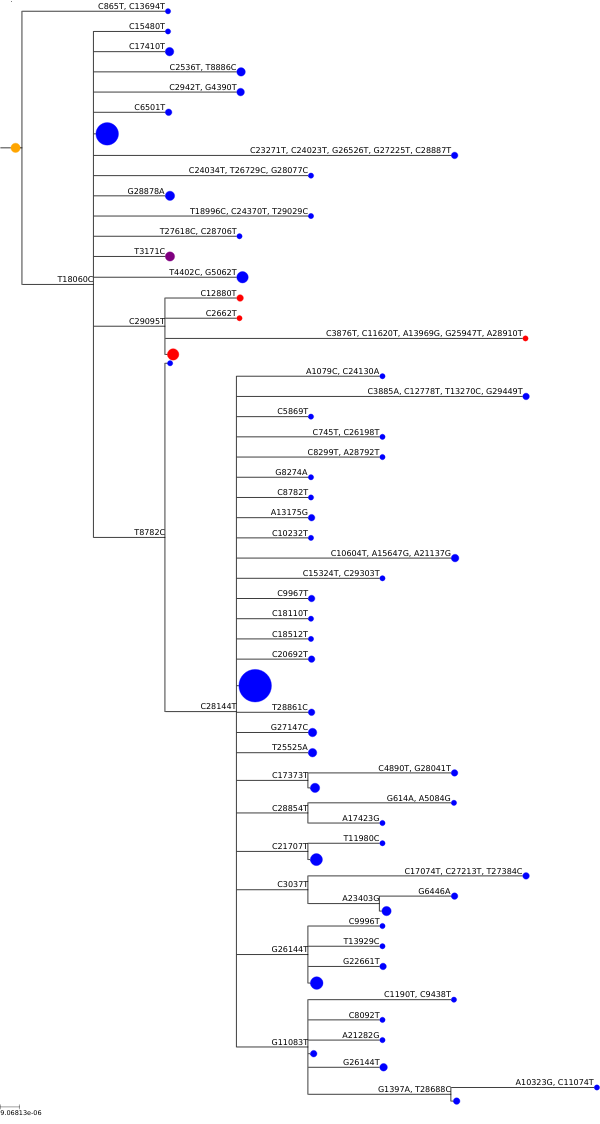

hCoV-19/Guangdong/HKU-SZ-002/2020


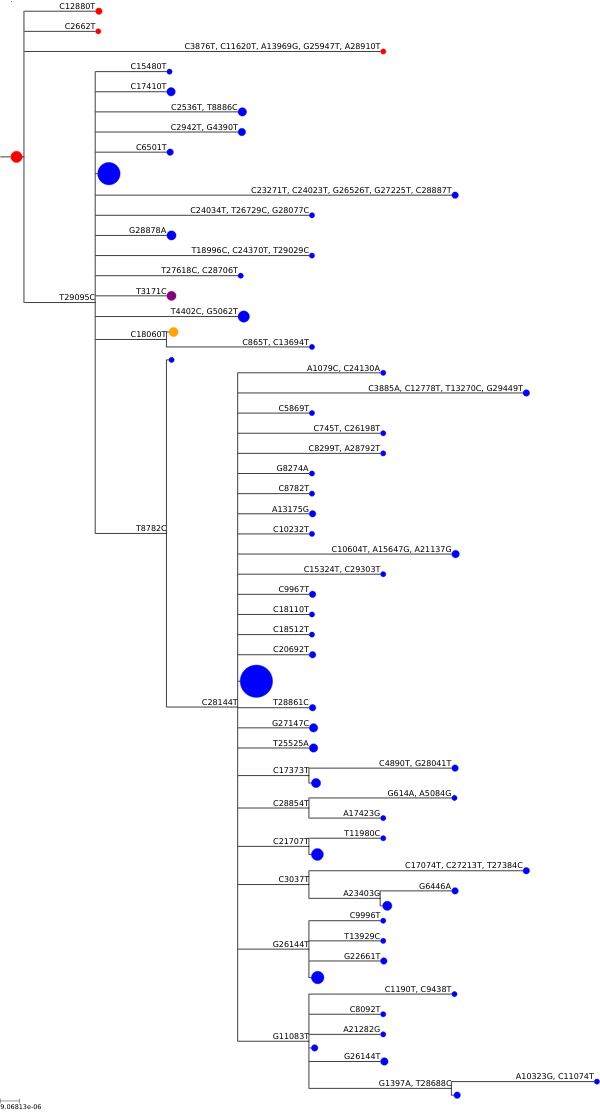

hCoV-19/Shandong/LY005-2/2020


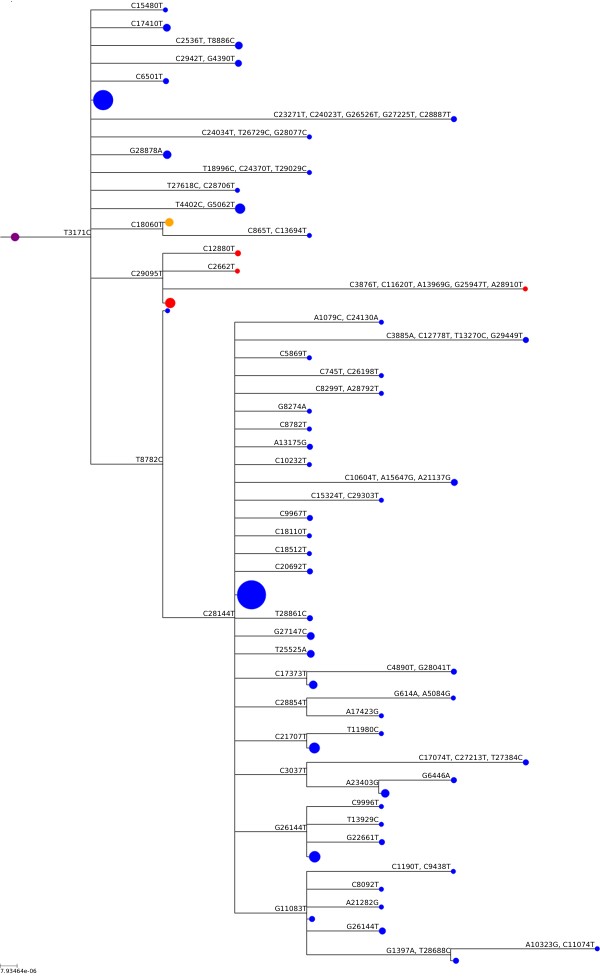

In [27]:
def get_pretty_tree(treefile,
                    df,
                    subs_matrix,
                    progenitor,
                    widthscale=1500,
                    heightscale=1,
                    nodesizescale=10,
                    rootlength=0.05,
                    label_nodes=False,
                    label_fontsize=15,
                    ):
    """Returns `(tree, tree_style)`."""
    annotations = df.set_index('representative_strain').to_dict(orient='index')
   
    t = ete3.Tree(treefile, format=1)

    ts = ete3.TreeStyle()
    ts.show_leaf_name = False  # add tip names manually
    height = t.get_farthest_node()[1]
    ts.scale = widthscale / height
    ts.branch_vertical_margin = heightscale
     
    nstyle_dict = {'hz_line_width': 2,
                   'vt_line_width': 2,
                   'hz_line_color': 'black',
                   'vt_line_color': 'black'}

    # label nodes
    for n in t.traverse():
        if n != t:
            subs = subs_matrix[(n.up.name, n.name)]
            if subs:
                n.add_face(ete3.TextFace(subs,
                                         fsize=label_fontsize),
                           position='branch-top',
                           column=0,
                           )
        if n.name == 'dummy':
            continue
        
        nstyle = ete3.NodeStyle(**nstyle_dict)
        
        if n.is_leaf() or n.name == progenitor:
            nstyle['size'] = nodesizescale * math.sqrt(annotations[n.name]['nstrains'])
            if label_nodes:
                n.add_face(ete3.TextFace(annotations[n.name]['substitutions'],
                                         tight_text=True,
                                         fsize=labelfontsize,
                                         ),
                           column=0,
                           position='branch-right',
                           )
            if annotations[n.name]['nstrains'] == 1:
                nstyle['fgcolor'] = 'gray'
            elif 'T3171C' in annotations[n.name]['substitutions']:
                nstyle['fgcolor'] = 'purple'
            elif 'C29095T' in annotations[n.name]['substitutions']:
                nstyle['fgcolor'] = 'red'
            elif not annotations[n.name]['substitutions']:
                nstyle['fgcolor'] = 'orange'
            else:
                nstyle['fgcolor'] = 'blue'
            
        else:
            nstyle['size'] = 0
        
        n.set_style(nstyle)
        
    # set dummy node for root, this allows us to put
    # progenitor at base of root branch
    progenitor_n = t.search_nodes(name=progenitor)
    assert len(progenitor_n) == 1
    progenitor_n = progenitor_n[0]
    dummy_outgroup = progenitor_n.add_child(name='dummy',
                                            dist=1e-5)
    t.set_outgroup(dummy_outgroup)
    assert len(progenitor_n.children) == 1
    progenitor_child = progenitor_n.children[0]
    nstyle = ete3.NodeStyle(size=0,
                            **nstyle_dict)
    progenitor_child.set_style(nstyle)
    if progenitor_n.faces:
        progenitor_child._faces = progenitor_n.faces
        delattr(progenitor_n, '_faces')
    empty_nstyle = ete3.NodeStyle(hz_line_color='white',
                                  vt_line_color='white',
                                  size=0)
    dummy_outgroup.set_style(empty_nstyle)
    dummy_outgroup.up.set_style(empty_nstyle)
        
    t.ladderize()
    
    return t, ts

assert len(progenitors) == len(tree_files)
for progenitor, tree_file in zip(progenitors, tree_files):
    print(progenitor)
    t, ts = get_pretty_tree(tree_file,
                            df=all_df,
                            subs_matrix=subs_matrices[progenitor],
                            progenitor=progenitor,
                            )
    display(t.render('%%inline', tree_style=ts, w=600))